**Toxic Commend Classification - Data Inspection and Processing (1)**

- Loading the data into the notebook
- Gaining a first impression
- Analysing training data in detail
- Dealing with significant imbalances in the class distribution
- Data processing with NLP Pipelibe

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**1. Data Loading**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
from wordcloud import WordCloud
import re
import collections

In [2]:
# Load and read all datasets efficently together
# Put four files into a list
csv_files = ['train.csv', 'test.csv', 'sample_submission.csv', 'test_labels.csv']

# Dictionary to store DataFrames
dfs = {}

# Load each CSV file and store its DataFrame in the dictionary
for file in csv_files:
    name = file.split('.')[0]
    dfs[name] = pd.read_csv(file)

# Loop through the DataFrames and inspect each one
for name, df in dfs.items():
    print(f"DataFrame from {name}.csv:")
    print(df.head())
    print("Columns:")
    print(df.columns)
    print()

DataFrame from train.csv:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
Columns:
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object'

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**2. First Impression**
- Inspecting the training data, checking the toxic classes distribution. 
- Inspection of the class features to determine what type of classification problem is involved.

In [5]:
train_df = dfs["train"]
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Check class frequency
lable_counts = train_df.iloc[:, 2:].sum().sort_values()
print(lable_counts)
print('\n')

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64




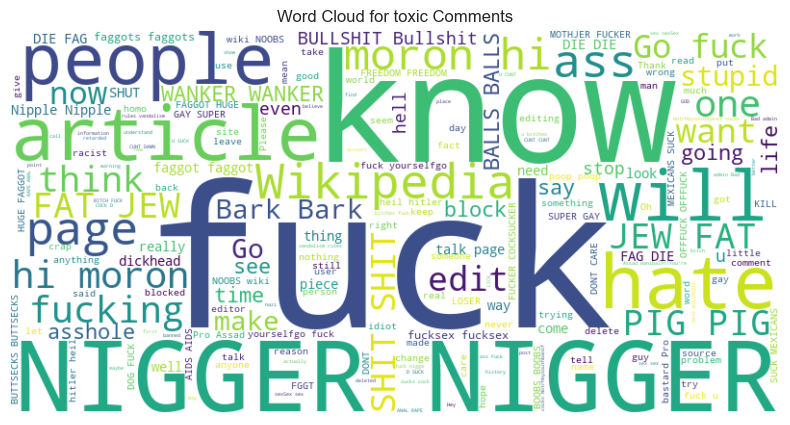

In [11]:
def create_word_map(dataframe, class_label, stopwords=None):
    # Filter dataframe to get comments belonging to the specified class
    class_comments = dataframe[dataframe[class_label] == 1]

    # Concatenate all comments into a single string
    text = ' '.join(class_comments['comment_text'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color='white').generate(text)

    # Display word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {class_label} Comments")
    plt.axis('off')
    plt.show()

# Display some examples of toxic comments
create_word_map(train_df, 'toxic')

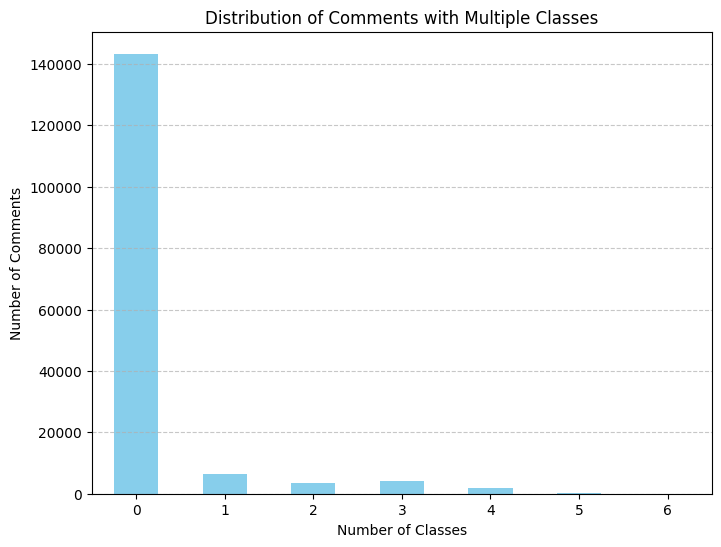

In [6]:
# Check class overlap
# Define the number of classes for each comment
num_classes = (train_df.iloc[:, 2:].astype(int) > 0).sum(axis=1)

# Count the frequency of comments with different numbers of classes
class_counts = num_classes.value_counts()

# Plot the distribution of comments with multiple classes
plt.figure(figsize=(8, 6))
class_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Comments with Multiple Classes')
plt.xlabel('Number of Classes')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

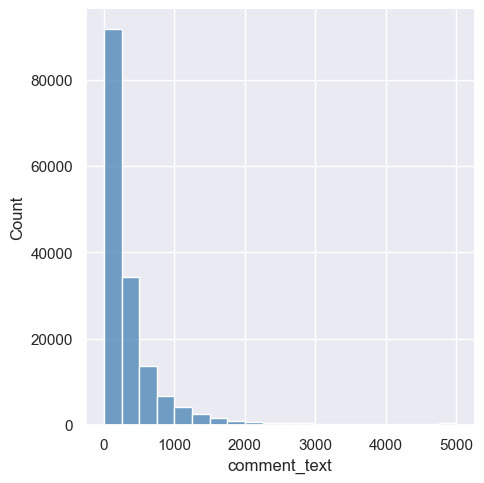

In [7]:
# Comment length distribution
sns.set(color_codes=True)
comment_len = train_df.comment_text.str.len()
sns.displot(comment_len, kde=False, bins=20, color="steelblue")

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**3. Analysing Training Data in Detail**

- Analysis of the comments distribution for each class(label)
- Relationship between the classes

In [7]:
# Define the target_column according to submission example
target_columns = list(dfs["sample_submission"].columns.drop("id"))
target_columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

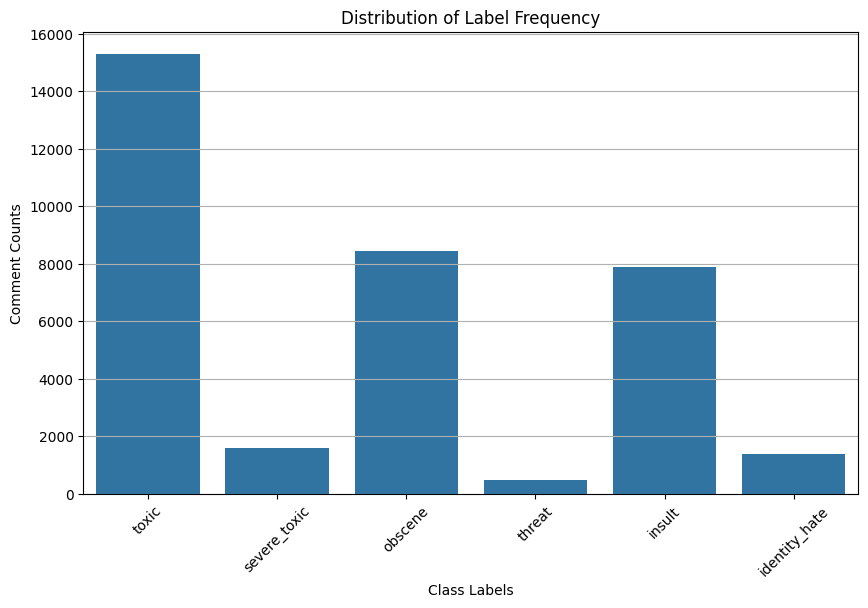

In [8]:
# Comments distribution for each toxic related class
classlabel_counts = train_df[target_columns].sum()

# Plot the class labels and their counts
plt.figure(figsize=(10, 6))
sns.barplot(x=classlabel_counts.index, y=classlabel_counts.values)
plt.title('Distribution of Label Frequency')
plt.xlabel('Class Labels')
plt.ylabel('Comment Counts')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

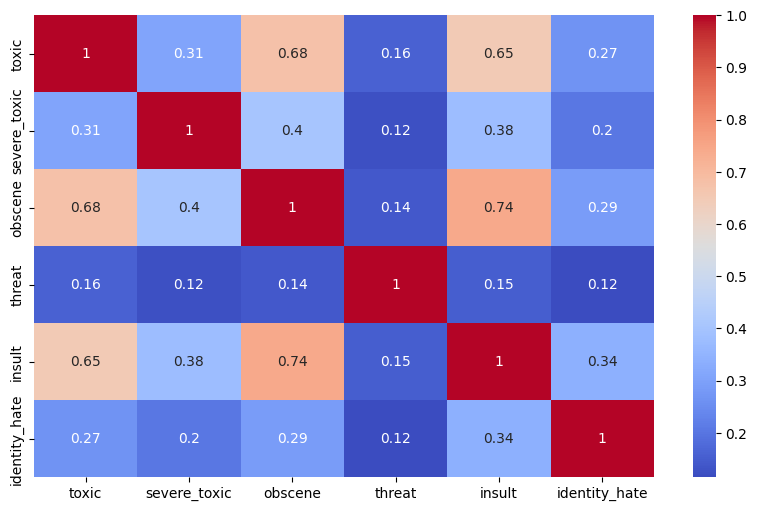

In [9]:
# Visulise correlations among classes
heatmap_data = train_df[target_columns]
plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data.corr(), cmap='coolwarm', annot=True)
ax.tick_params(labelsize=10)

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**4. Handeling Data Imbalance**

- Visulisation of the data imbalance
- Balance the dataset, create a new training set

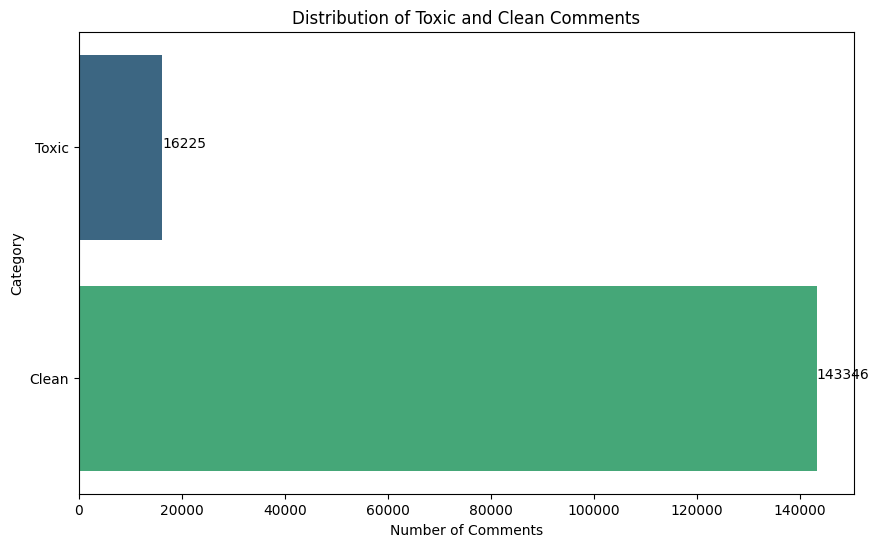

In [10]:
# Create subsets based on toxic and clean comments
train_toxic = train_df[train_df[target_columns].sum(axis=1) > 0]
train_clean = train_df[train_df[target_columns].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create a DataFrame for visualization
plot_data = pd.DataFrame({'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

# Visualization
plt.figure(figsize=(10, 6))
# Horizontal bar plot
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis',hue='Category',dodge=False, legend=False )
# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')
# Add count labels on each bar
for index, value in enumerate(plot_data['Count']):
    plt.text(value, index, str(value))
plt.show()

In [11]:
# Handling class imbalance
# Randomly sample 16225 clearn comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)
#Combine the toxic and sampled clean comments
df = pd.concat([train_toxic, train_clean_sampled], axis=0)
#Shuffle the data 
df = df.sample(frac = 1, random_state=42)

In [12]:
df.shape

(32450, 8)

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**5. Data Processing with NLP Pipeline**

- Clean text, tokenisation, lemmatisation 

In [12]:
!python -m spacy download en_core_web_lg

     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     --------------------------------------- 0.5/587.7 MB 15.4 MB/s eta 0:00:39
     --------------------------------------- 1.6/587.7 MB 20.4 MB/s eta 0:00:29
     --------------------------------------- 2.7/587.7 MB 19.2 MB/s eta 0:00:31
     --------------------------------------- 3.8/587.7 MB 20.2 MB/s eta 0:00:29
     --------------------------------------- 4.8/587.7 MB 20.6 MB/s eta 0:00:29
     --------------------------------------- 6.3/587.7 MB 22.2 MB/s eta 0:00:27
     --------------------------------------- 7.3/587.7 MB 22.1 MB/s eta 0:00:27
      -------------------------------------- 8.4/587.7 MB 21.6 MB/s eta 0:00:27
      ------------------------------------- 10.0/587.7 MB 22.9 MB/s eta 0:00:26
      ------------------------------------- 11.1/587.7 MB 24.2 MB/s eta 0:00:24
      ------------------------------------- 12.4/587.7 MB 25.2 MB/s eta 0:00:23
      ------------------------------------- 13.


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# Load the language model
nlp = spacy.load("en_core_web_lg")

In [14]:
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [15]:
token_nonstop = []
lemmas = []
number_tokens = []
number_sentences = []

for text in df["comment_text"].astype("unicode").values:
    # Preprocessing steps
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    text = re.sub('@[^\s]+', '', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text = re.sub(r'[\!:\?\-\'\"\\/]', r'', text)
    text = re.sub('[\s]+', ' ', text)

    # Process text with spaCy
    doc = nlp(text)
    if doc.has_annotation("DEP"):
        token_nonstop.append([t.text for t in doc if t.is_alpha and not t.is_stop])
        lemmas.append([t.lemma_ for t in doc if t.is_alpha and not t.is_stop])
        number_tokens.append(len([t for t in doc if t.is_alpha and not t.is_stop]))
        number_sentences.append(sum(1 for _ in doc.sents))
    else:
        token_nonstop.append(None)
        lemmas.append(None)
        number_tokens.append(None)
        number_sentences.append(None)

df['token_nonstop'] = token_nonstop
df['lemmas'] = lemmas
df['number_tokens'] = number_tokens
df['number_sentences'] = number_sentences

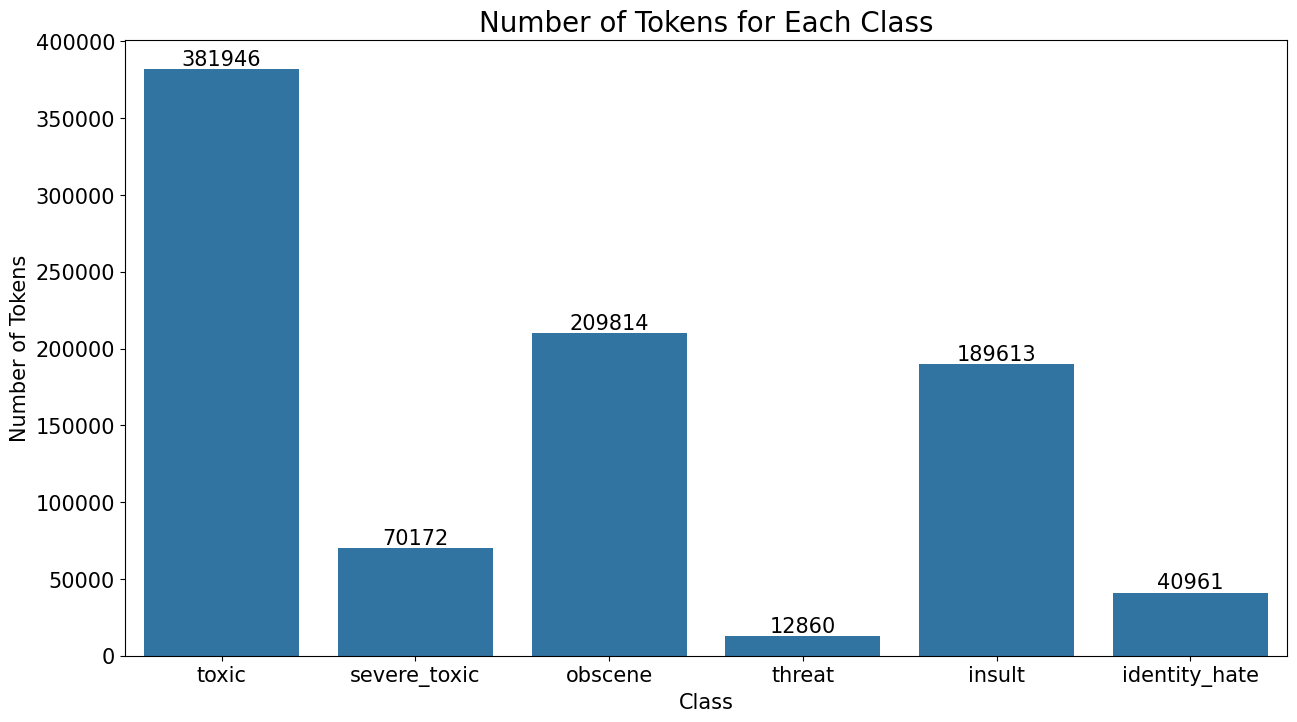

In [16]:
# Calculate the number of tokens for each class
counts = []

for label in target_columns:
    counts.append(df.loc[df[label]==1, 'number_tokens'].sum())
    
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=target_columns, y=counts)

for i, count in enumerate(counts):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=15)
ax.tick_params(labelsize=15)
plt.title('Number of Tokens for Each Class', fontsize=20)
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of Tokens', fontsize=15)
plt.show()

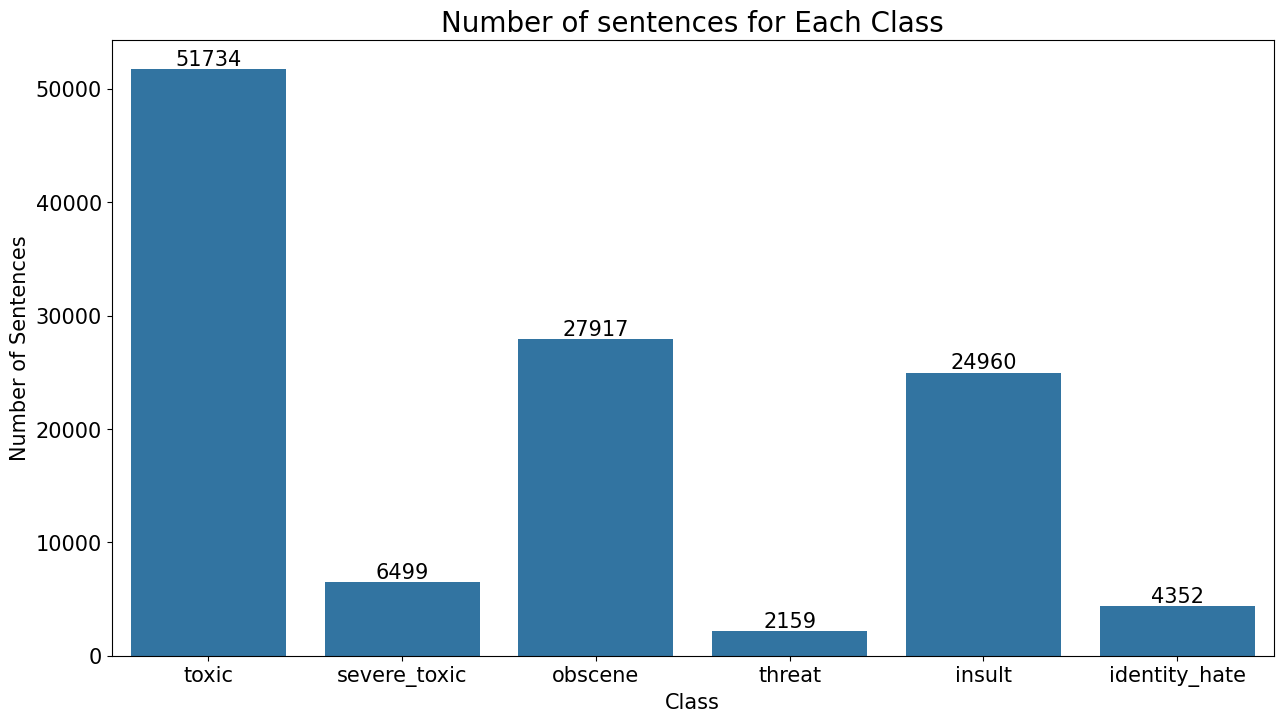

In [17]:
# Calculate the number of sentence for each class
counts = []

for label in target_columns:
    counts.append(df.loc[df[label]==1, 'number_sentences'].sum())
    
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=target_columns, y=counts)

for i, count in enumerate(counts):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=15)
ax.tick_params(labelsize=15)
plt.title('Number of sentences for Each Class', fontsize=20)
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of Sentences', fontsize=15)
plt.show()

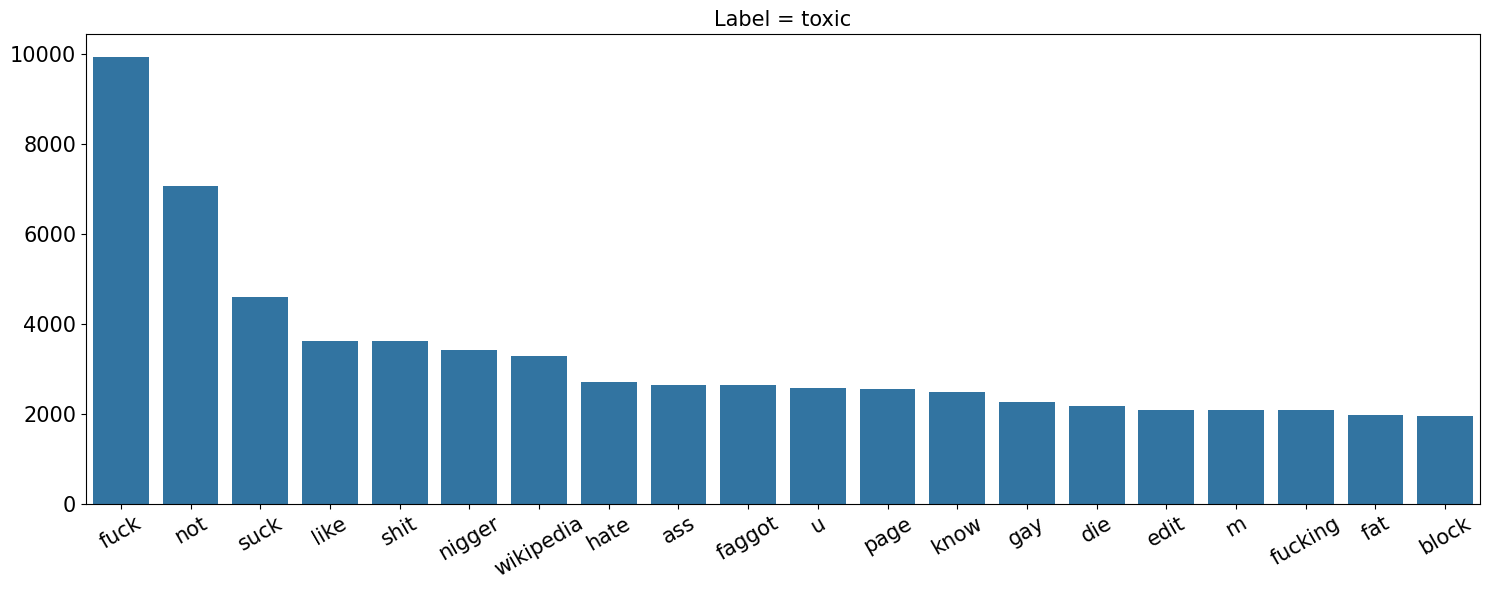

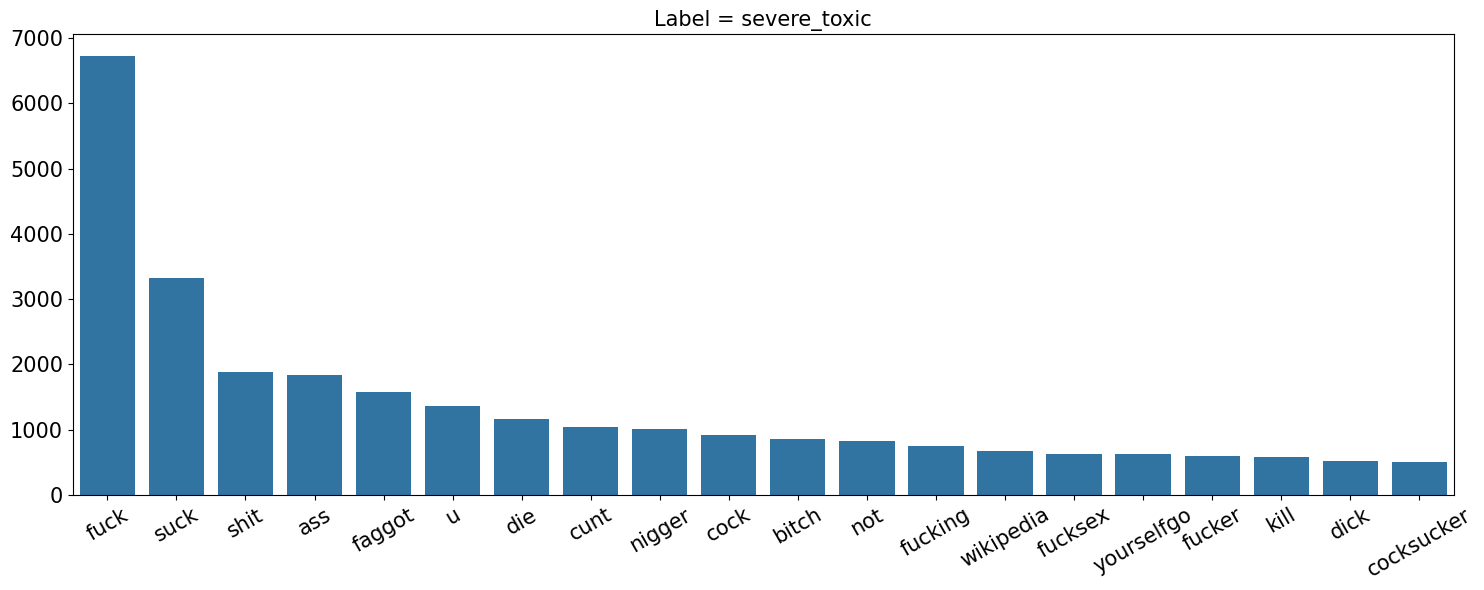

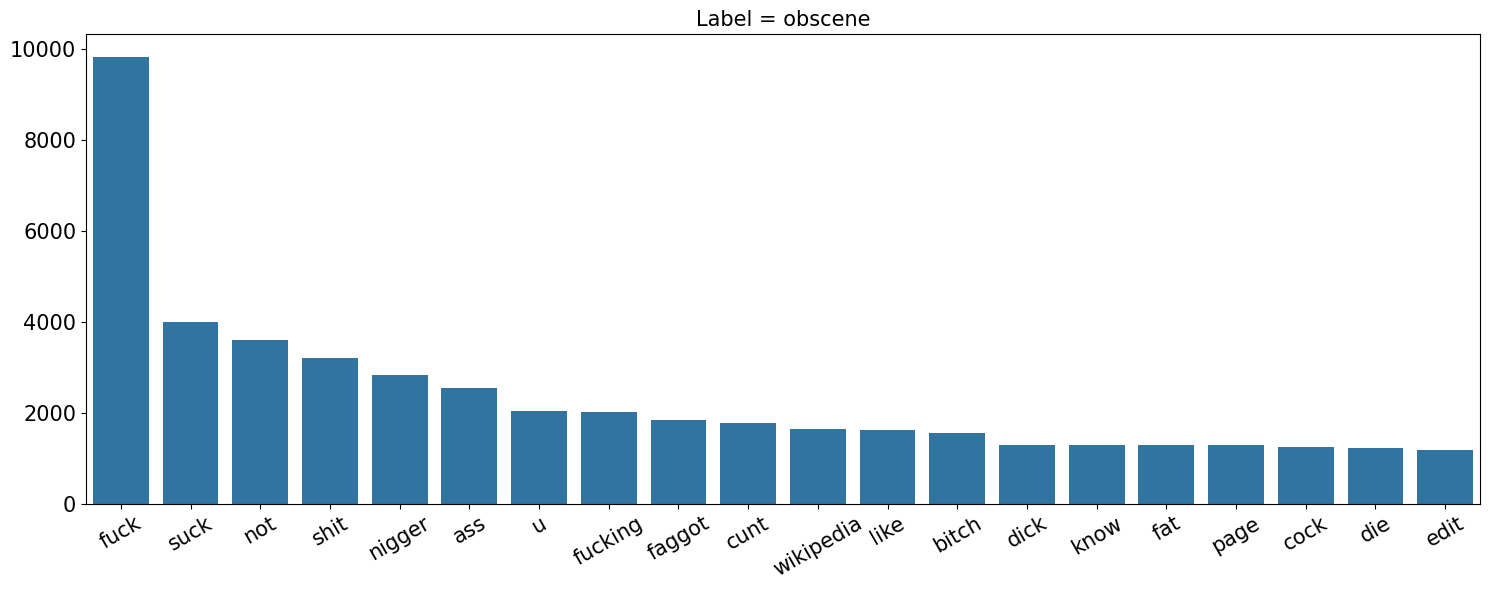

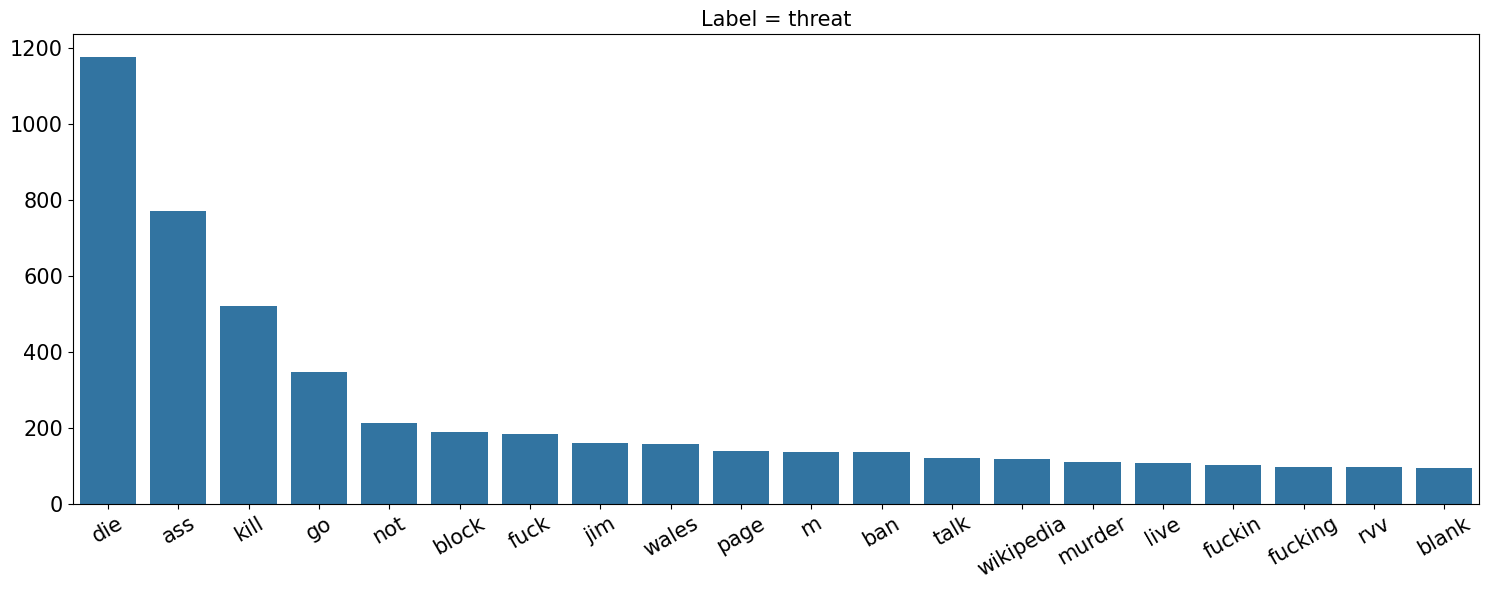

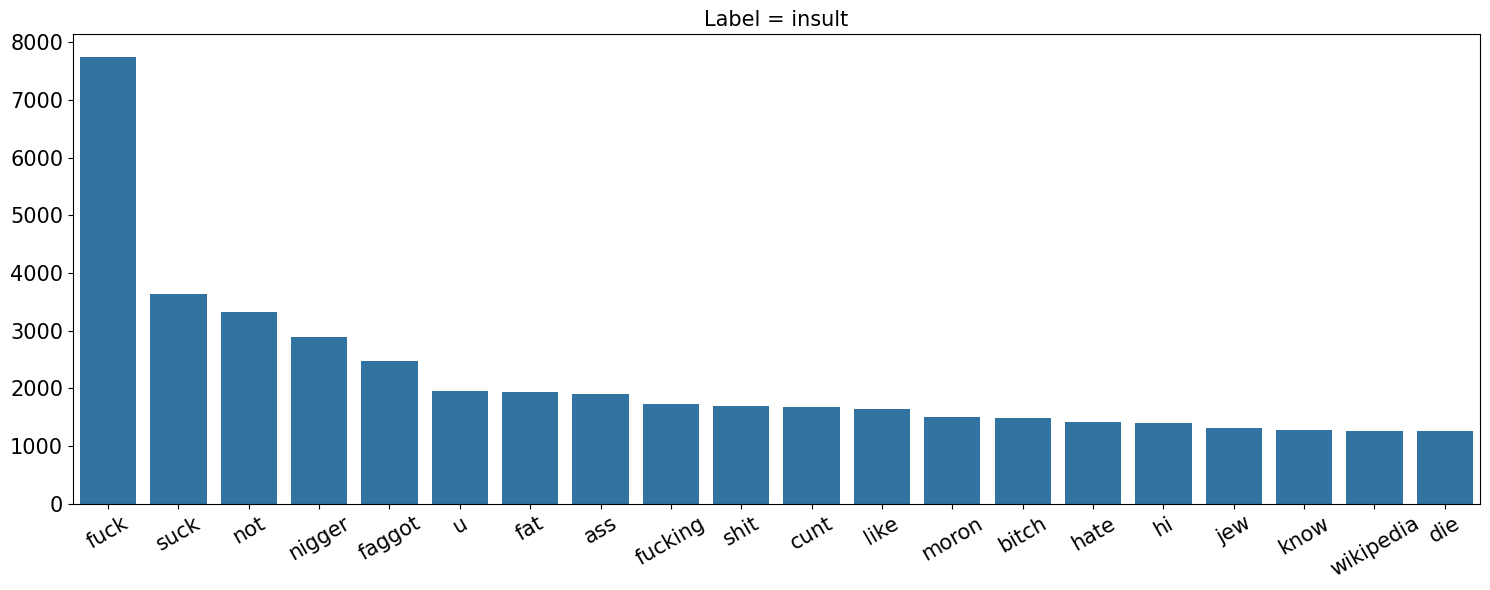

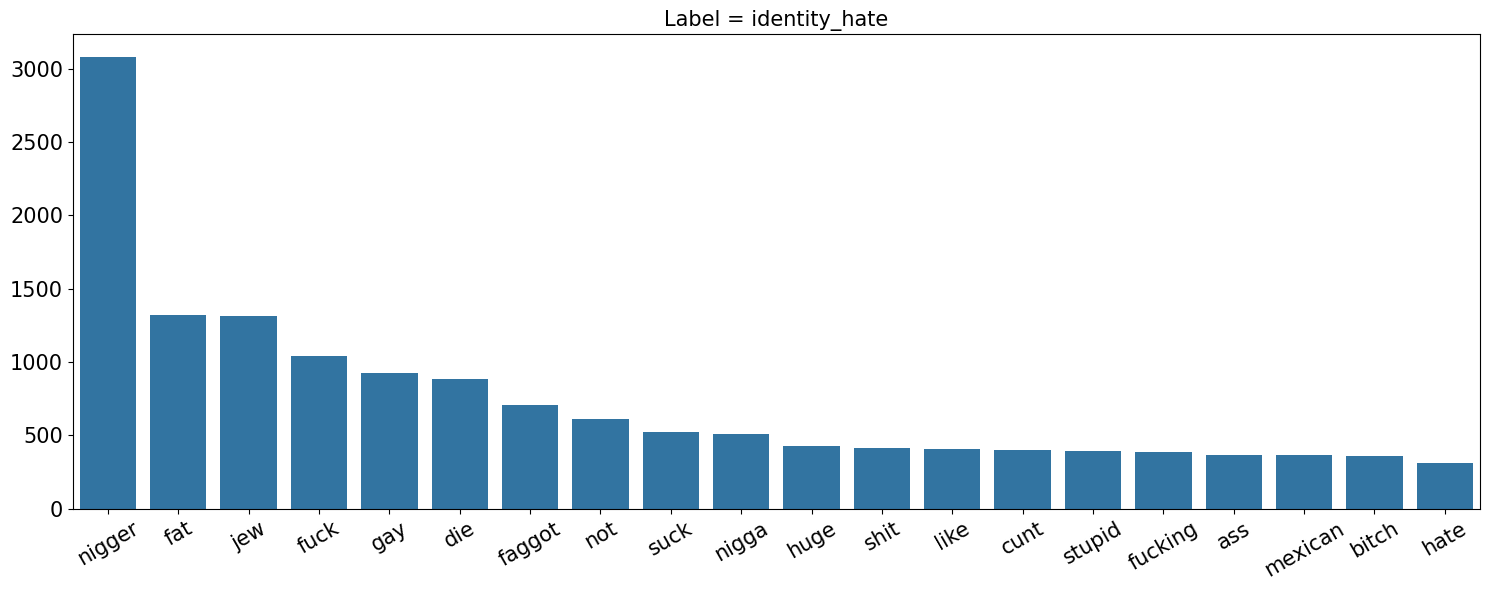

In [18]:
# Find the most common lemmas for each class
for label in target_columns:
    word_list = list(df.loc[df[label]==1, 'lemmas'].explode())
    most_common = collections.Counter(word_list).most_common(20)
    words = [w for w,_ in most_common]
    counts = [c for _,c in most_common]
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x=words, y=counts)
    ax.set_title(f'Label = {label}', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.tight_layout() 
    plt.show()

In [19]:
df.to_csv('processed_train_data.csv', index=False)